In [1]:
import numpy as np
import re
from math import sin, cos, sqrt

def calculate_index(bands, index_name, params=None):
    """
    Вычисляет вегетационный индекс на основе доступных каналов.
    
    Параметры:
        bands (dict): Словарь с массивами numpy
        index_name (str): Аббревиатура индекса
        params (dict): Дополнительные параметры для индексов
    
    Возвращает:
        np.array: Рассчитанный индекс
    """
    if params is None:
        params = {}

    for band_name, band_data in bands.items():
        if not isinstance(band_data, np.ndarray):
            raise ValueError(f"Band '{band_name}' должен быть numpy.ndarray")
    
    # Словарь с функциями для индексов
    index_functions = {
        "ARVI": lambda: calculate_ARVI(bands, params),
        "DVI": lambda: calculate_DVI(bands),
        "EVI": lambda: calculate_EVI(bands, params),
        "GEMI": lambda: calculate_GEMI(bands),
        "GVI": lambda: calculate_GVI(bands, params),
        "IPVI": lambda: calculate_IPVI(bands),
        "MSAVI1": lambda: calculate_MSAVI1(bands, params),
        "MSAVI2": lambda: calculate_MSAVI2(bands),
        "NDVI": lambda: calculate_NDVI(bands),
        "PVI": lambda: calculate_PVI(bands, params),
        "RVI": lambda: calculate_RVI(bands),
        "SARVI": lambda: calculate_SARVI(bands, params),
        "SAVI": lambda: calculate_SAVI(bands, params),
        "TSAVI": lambda: calculate_TSAVI(bands, params),
        "TVI": lambda: calculate_TVI(bands),
        "WDVI": lambda: calculate_WDVI(bands, params)
    }
    
    if index_name not in index_functions:
        raise ValueError(f"Неизвестный индекс: {index_name}. Доступные индексы: {list(index_functions.keys())}")
    
    try:
        return index_functions[index_name]()
    except (KeyError, ValueError) as e:
        raise ValueError(f"Не удалось вычислить индекс {index_name}: {str(e)}")

def safe_divide(numerator, denominator):
    """Деление с проверкой на 0 и NaN.
    
    Возвращает результат деления.
    
    Вызывает:
        ValueError: если в знаменателе есть 0 или NaN.
    """
    if np.any(denominator == 0):
        raise ValueError("Деление на ноль!")
    if np.any(np.isnan(denominator)):
        raise ValueError("Деление на NaN!")
    return numerator / denominator

def extract_parameters(formula_str, params):
    """Извлекает параметры из формулы"""
    pattern = r'\b([a-zA-Zαρ]+)\b'
    required_params = set(re.findall(pattern, formula_str)) - {'NIR', 'RED', 'BLUE', 'sqrt', 'sin', 'cos'}
    missing = required_params - set(params.keys())
    if missing:
        raise ValueError(f"Не хватает параметров: {missing}")
    return {k: params[k] for k in required_params}

In [2]:
def calculate_ARVI(bands, params=None):
    """
    Вычисляет Atmospherically Resistant Vegetation Index (ARVI).
    
    Формула:
    ARVI = (NIR - Rb) / (NIR + Rb)
    где Rb = RED - a*(RED - BLUE)
    
    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    - BLUE (синий)
    
    Параметры:
    - a (float): коэффициент атмосферной коррекции (по умолчанию 1.0)
    
    Возвращает:
    - np.ndarray: массив значений ARVI
    """
    required = ['NIR', 'RED', 'BLUE']
    if not all(b in bands for b in required):
        raise ValueError(f"Для ARVI требуются каналы: {required}")
    if params is None:
        params = {}
    nir, red, blue = bands["NIR"], bands["RED"], bands["BLUE"]
    a = params.get('a', 1.0)
    Rb = red - a * (red - blue)
    
    arvi = safe_divide(nir - Rb, nir + Rb)
    
    # Проверка диапазона
    if np.any((arvi < -1) | (arvi > 1)):
        raise ValueError("ARVI должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
    
    return arvi

In [3]:
def calculate_DVI(bands):
    """
    Вычисляет Difference Vegetation Index (DVI).
    
    Формула:
    DVI = NIR - RED
    
    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    
    Возвращает:
    - np.ndarray: массив значений DVI
    """
    required = ['NIR', 'RED']
    if not all(b in bands for b in required):
        raise ValueError(f"Для DVI требуются каналы: {required}")
    nir, red = bands["NIR"], bands["RED"]
    return nir - red

In [4]:
def calculate_EVI(bands, params=None):
    """
    Вычисляет Enhanced Vegetation Index (EVI).
    
    Формула:
    EVI = (1 + L) * (NIR - RED) / (NIR + C1*RED - C2*BLUE + L)
    
    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    - BLUE (синий)
    
    Параметры:
    - C1 (float): коэффициент коррекции красного канала (по умолчанию 6.0)
    - C2 (float): коэффициент коррекции синего канала (по умолчанию 7.5)
    - L (float): коэффициент коррекции почвенного фона (по умолчанию 1.0)
    
    Возвращает:
    - np.ndarray: массив значений EVI
    """
    required = ['NIR', 'RED', 'BLUE']
    if not all(b in bands for b in required):
        raise ValueError(f"Для ARVI требуются каналы: {required}")
    if params is None:
        params = {}
    nir, red, blue = bands["NIR"], bands["RED"], bands["BLUE"]
    C1 = params.get('C1', 6.0)
    C2 = params.get('C2', 7.5)
    L = params.get('L', 1.0)

    evi = (1 + L) * safe_divide(nir - red, nir + C1*red - C2*blue + L)
    
    # Проверка диапазона
    if np.any((evi < -1) | (evi > 1)):
        raise ValueError("EVI должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
    
    return evi

In [5]:
def calculate_GEMI(bands):
    """
    Вычисляет Global Environmental Monitoring Index (GEMI).
    Формула:
    GEMI = E*(1 - 0.25*E) - (RED - 0.125)/(1 - RED)
    где E = [2*(NIR² - RED²) + 1.5*NIR + 0.5*RED]/(NIR + RED + 0.5)

    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    
    Возвращает:
    - np.ndarray: массив значений GEMI
    """
    required = ['NIR', 'RED']
    if not all(b in bands for b in required):
        raise ValueError(f"Для GEMI требуются каналы: {required}")
    
    nir = bands['NIR']
    red = bands['RED']
    
    numerator = 2 * (nir**2 - red**2) + 1.5 * nir + 0.5 * red
    denominator = nir + red + 0.5
    E = safe_divide(numerator, denominator)
    
    term1 = E * (1 - 0.25 * E)
    term2 = safe_divide(red - 0.125, 1 - red)
    gemi = term1 - term2

    # Проверка диапазона
    if np.any((gemi < 0) | (gemi > 1)):
        raise ValueError("GEMI должен быть в диапазоне [0, 1]. Получены недопустимые значения.")
    
    return gemi

In [6]:
def calculate_GVI(bands, params=None):
    """
    Вычисляет Green Vegetation Index (GVI) для датчиков MSS или TM.
    
    Для датчика MSS:
    GVI = -0.29*MSS4 - 0.56*MSS5 + 0.6*MSS6 + 0.49*MSS7
    
    Для датчика TM:
    GVI = -0.2848*TM1 - 0.2435*TM2 - 0.5436*TM3 + 0.7243*TM4 + 0.0840*TM5 - 0.1800*TM7
    
    Требуемые каналы:
    Для MSS: MSS4, MSS5, MSS6, MSS7
    Для TM: TM1, TM2, TM3, TM4, TM5, TM7
    
    Параметры:
    - sensor (str): тип датчика ('MSS' или 'TM'), по умолчанию 'TM'
    
    Возвращает:
    - np.ndarray: массив значений GVI
    """
    if params is None:
        params = {}
    sensor = params.get('sensor', 'TM')
    if sensor == 'MSS':
        required = ['MSS4', 'MSS5', 'MSS6', 'MSS7']
        if not all(b in bands for b in required):
            raise ValueError(f"Для GVI (MSS) требуются каналы: {required}")
        gvi = (-0.29*bands['MSS4'] - 0.56*bands['MSS5'] + 0.6*bands['MSS6'] + 0.49*bands['MSS7'])
        
        # Проверка диапазона
        if np.any((gvi < -1) | (gvi > 1)):
            raise ValueError("GVI должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
        return gvi
    else:  # TM по умолчанию
        required = ['TM1', 'TM2', 'TM3', 'TM4', 'TM5', 'TM7']
        if not all(b in bands for b in required):
            raise ValueError(f"Для GVI (TM) требуются каналы: {required}")
        gvi = (-0.2848*bands['TM1'] - 0.2435*bands['TM2'] - 0.5436*bands['TM3'] + 0.7243*bands['TM4'] + 0.0840*bands['TM5'] - 0.1800*bands['TM7'])
        
        # Проверка диапазона
        if np.any((gvi < -1) | (gvi > 1)):
            raise ValueError("GVI должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
        return gvi

In [7]:
def calculate_IPVI(bands):
    """
    Вычисляет Infrared Percentage Vegetation Index (IPVI).
    
    Формулы:
    1. IPVI = NIR / (NIR + RED)
    2. Если NIR и RED недоступны: IPVI = (NDVI + 1) / 2
    
    Требуемые каналы:
    - NIR (ближний инфракрасный) и RED (красный), либо
    - Возможность расчёта NDVI
    
    Возвращает:
    - np.ndarray: массив значений IPVI
    """
    try:
        ipvi = safe_divide(bands["NIR"], bands["NIR"] + bands["RED"])
        if np.any((ipvi < 0) | (ipvi > 1)):
            raise ValueError("IPVI должен быть в диапазоне [0, 1]. Получены недопустимые значения.")
        return ipvi
    except KeyError:
        try:
            ndvi = calculate_NDVI(bands)
            ipvi = (ndvi + 1) / 2
            if np.any((ipvi < 0) | (ipvi > 1)):
                raise ValueError("IPVI должен быть в диапазоне [0, 1]. Получены недопустимые значения.")
            return ipvi
        except:
            raise ValueError("Для IPVI нужны либо NIR и RED, либо расчет NDVI")

In [8]:
def calculate_NDVI(bands):
    """
    Вычисляет Normalized Difference Vegetation Index (NDVI).
    
    Формулы:
    1. NDVI = (NIR - RED) / (NIR + RED)
    2. Если NIR и RED недоступны: NDVI = (RVI - 1) / (RVI + 1)
    
    Требуемые каналы:
    - NIR (ближний инфракрасный) и RED (красный), либо
    - Возможность расчёта RVI
    
    Возвращает:
    - np.ndarray: массив значений NDVI
    """
    try:
        ndvi = safe_divide(bands["NIR"] - bands["RED"], bands["NIR"] + bands["RED"])
        if np.any((ndvi < -1) | (ndvi > 1)):
            raise ValueError("NDVI должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
        return ndvi
    except KeyError:
        try:
            rvi = calculate_RVI(bands)
            ndvi = (rvi - 1) / (rvi + 1)
            if np.any((ndvi < -1) | (ndvi > 1)):
                raise ValueError("NDVI должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
            return ndvi
        except:
            raise ValueError("Для NDVI нужны либо NIR и RED, либо расчет RVI")

In [9]:
def calculate_WDVI(bands, params):
    """
    Вычисляет Weighted Difference Vegetation Index.
    
    Формула:
    WDVI = NIR - ρ * RED
    
    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    
    Параметры:
    - rho (float): наклон почвенной линии
    """
    required = ['NIR', 'RED']
    if not all(b in bands for b in required):
        raise ValueError(f"Для WDVI требуются каналы: {required}")
    
    if 'rho' not in params:
        raise ValueError("Для WDVI требуется параметр 'rho'")
    
    nir = bands['NIR']
    red = bands['RED']
    rho = params['rho']
    
    return nir - rho * red

In [10]:
def calculate_MSAVI1(bands, params=None):
    """
    Вычисляет Modified Soil Adjusted Vegetation Index 1 (MSAVI1).
    
    Формула:
    MSAVI1 = (NIR - RED) / (NIR + RED - L) * (1 + L)
    где L = 1 - 2 * s * NDVI * WDVI
    
    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    
    Параметры:
    - s (float): коэффициент масштабирования (по умолчанию 1.0)
    - rho (float): наклон почвенной линии
    
    Возвращает:
    - np.ndarray: массив значений MSAVI1
    """
    if params is None:
        params = {}
    
    required = ['NIR', 'RED']
    if not all(b in bands for b in required):
        raise ValueError(f"Для MSAVI1 требуются каналы: {required}")
    
    nir = bands['NIR']
    red = bands['RED']
    s = params.get('s', 1.0)
    
    ndvi = calculate_NDVI(bands)
    wdvi = calculate_WDVI(bands, params)
    
    L = 1 - 2 * s * ndvi * wdvi
    
    msavi1 = safe_divide(nir - red, nir + red - L) * (1 + L)

    if np.any((msavi1 < -1) | (msavi1 > 1)):
        raise ValueError("MSAVI1 должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
    
    return msavi1

In [11]:
def calculate_MSAVI2(bands):
    """
    Вычисляет Modified Soil Adjusted Vegetation Index 2 (MSAVI2).
    
    Формула:
    MSAVI2 = (NIR - RED) / (NIR + RED - L) * (1 + L)
    где L = 1 - (2*NIR + 1 - sqrt((2*NIR + 1)² - 8*(NIR - RED))) / 2
    
    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    
    Возвращает:
    - np.ndarray: массив значений MSAVI2
    """
    required = ['NIR', 'RED']
    if not all(b in bands for b in required):
        raise ValueError(f"Для MSAVI2 требуются каналы: {required}")
    
    nir = bands['NIR']
    red = bands['RED']
    
    term = (2 * nir + 1)**2 - 8 * (nir - red)
    if np.any(term < 0):
        raise ValueError("Отрицательное значение под корнем.")
    sqrt_term = np.sqrt(term)
    L = 1 - (2 * nir + 1 - sqrt_term) / 2
    
    msavi2 = safe_divide(nir - red, nir + red - L) * (1 + L)
    
    if np.any((msavi2 < -1) | (msavi2 > 1)):
        raise ValueError("MSAVI2 должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
    
    return msavi2

In [12]:
def calculate_PVI(bands, params=None):
    """
    Вычисляет Perpendicular Vegetation Index (PVI).
    
    Формула:
    PVI = sin(α)*NIR - cos(α)*RED
    
    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    
    Параметры:
    - alpha (float): угол в радианах (обязательный параметр)
    
    Возвращает:
    - np.ndarray: массив значений PVI
    """
    required = ['NIR', 'RED']
    if not all(b in bands for b in required):
        raise ValueError(f"Для PVI требуются каналы: {required}")
    if params is None:
        params = {}
    if 'alpha' not in params:
        raise ValueError("Для PVI требуется параметр 'alpha' (угол в радианах)")
    
    nir = bands['NIR']
    red = bands['RED']
    alpha = params['alpha']
    
    pvi = np.sin(alpha) * nir - np.cos(alpha) * red
    if np.any((pvi < -1) | (pvi > 1)):
            raise ValueError("PVI должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
    return pvi

In [13]:
def calculate_RVI(bands):
    """
    Вычисляет Ratio Vegetation Index (RVI).
    
    Формула:
    RVI = NIR / RED
    
    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    
    Возвращает:
    - np.ndarray: массив значений RVI
    """
    required = ['NIR', 'RED']
    if not all(b in bands for b in required):
        raise ValueError(f"Для RVI требуются каналы: {required}")
    nir, red = bands["NIR"], bands["RED"]
    rvi = safe_divide(nir, red)
    if np.any(rvi < -1):
            raise ValueError("RVI должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
    return rvi

In [14]:
def calculate_SARVI(bands, params=None):
    """
    Вычисляет Soil and Atmospherically Resistant Vegetation Index.
    
    Формула:
    SARVI = (NIR - Rb) / (NIR + Rb + L) * (1 + L)
    где Rb = RED - a*(RED - BLUE)
    
    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    - BLUE (синий)
    
    Параметры:
    - a (float): атмосферный параметр (по умолчанию 1.0)
    - L (float): почвенный параметр (по умолчанию 0.5)
    """
    if params is None:
        params = {}
    
    a = params.get('a', 1.0)
    L = params.get('L', 0.5)
    
    required = ['NIR', 'RED']
    if not all(b in bands for b in required):
        raise ValueError(f"Для SARVI требуются каналы: {required}")
    
    nir = bands['NIR']
    red = bands['RED']
    blue = bands['BLUE']
    
    Rb = red - a * (red - blue)

    sarvi = safe_divide(nir - Rb, nir + Rb) * (1 + L)
    if np.any((sarvi < -1) | (sarvi > 1)):
            raise ValueError("SARVI должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
    return sarvi

In [15]:
def calculate_SAVI(bands, params=None):
    """
    Вычисляет Soil-Adjusted Vegetation Index (SAVI).

    Формула:
    SAVI = (1 + L) * (NIR - RED) / (NIR + RED + L)

    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)

    Параметры:
    - L (float): коэффициент коррекции почвенного фона (по умолчанию 0.5).
    
    Возвращает:
    - np.ndarray: массив значений SAVI
    """
    required = ['NIR', 'RED']
    if not all(b in bands for b in required):
        raise ValueError(f"Для SAVI требуются каналы: {required}")
    if params is None:
        params = {}
    nir, red = bands["NIR"], bands["RED"]
    L = params.get('L', 0.5)

    savi = safe_divide(nir - red, nir + red + L) * (1 + L)
    if np.any((savi < -1) | (savi > 1)):
            raise ValueError("SAVI должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
    return savi

In [16]:
def calculate_TSAVI(bands, params):
    """
    Вычисляет Transformed Soil Adjusted Vegetation Index.
    
    Формула:
    TSAVI = s*(NIR - s*RED - a) / (a*NIR + RED - a*s + X*(1 + s²))
    
    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    
    Параметры:
    - a (float): пересечение почвенной линии с осью NIR
    - s (float): наклон почвенной линии
    - X (float): коррекционный параметр (по умолчанию 0.08)
    """
    required = ['NIR', 'RED']
    if not all(b in bands for b in required):
        raise ValueError(f"Для TSAVI требуются каналы: {required}")
    
    if 'a' not in params or 's' not in params:
        raise ValueError("Для TSAVI требуются параметры 'a' и 's'")
    
    X = params.get('X', 0.08)
    a = params['a']
    s = params['s']
    
    nir = bands['NIR']
    red = bands['RED']
    
    numerator = s * (nir - s * red - a)
    denominator = a * nir + red - a * s + X * (1 + s**2)

    tsavi = safe_divide(numerator, denominator)
    
    if np.any((tsavi < -1) | (tsavi > 1)):
            raise ValueError("TSAVI должен быть в диапазоне [-1, 1]. Получены недопустимые значения.")
    return tsavi

In [17]:
def calculate_TVI(bands):
    """
    Вычисляет Transformed Vegetation Index.
    
    Формула:
    TVI = sqrt(NDVI + 0.5)
    
    Требуемые каналы:
    - NIR (ближний инфракрасный)
    - RED (красный)
    """
    required = ['NIR', 'RED']
    if not all(b in bands for b in required):
        raise ValueError(f"Для TVI требуются каналы: {required}")
    
    ndvi = calculate_NDVI(bands)
    tvi = ndvi + 0.5
    
    if np.any(tvi < 0):
        raise ValueError("Отрицательные значения под корнем (NDVI + 0.5 < 0)")
    
    return np.sqrt(tvi)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from torchgeo.datasets import EuroSAT

In [22]:
import zipfile
try:
    with zipfile.ZipFile("/Users/kiral/Downloads/Telegram Desktop/EuroSAT.zip") as z:
        print("Архив корректен.")
except zipfile.BadZipFile:
    print("Архив повреждён. Удалите его и скачайте заново.")

Архив корректен.


In [24]:
ds = EuroSAT(
    root="/Users/kiral/Downloads/Telegram Desktop/data",  # Полный путь
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
    download=True
)



00%|█████████████████████████████████████████████████████████████████████████████| 2.07G/2.07G [00:53<00:00, 38.3MB/s]

In [33]:
def show_available_indices():
    """Возвращает список доступных индексов, исключая GVI"""
    return [
        "ARVI", "DVI", "EVI", "GEMI", "IPVI", "MSAVI1", "MSAVI2",
        "NDVI", "PVI", "RVI", "SARVI", "SAVI", "TSAVI", "TVI", "WDVI"
    ]

def display_index_from_sample(sample, params=None):
    if params is None:
        params = {}

    img = sample["image"]  # [13, 64, 64]
    img_np = img.permute(1, 2, 0).numpy()  # [H, W, 13]
    #print(img_np)
    #print(img_np.shape)
    img_np = img_np / 10000

    band_map = {
        "B01": 0, "B02": 1, "B03": 2, "B04": 3, "B05": 4, "B06": 5, "B07": 6,
        "B08": 7, "B8A": 8, "B09": 9, "B10": 10, "B11": 11, "B12": 12
    }

    bands = {
        "BLUE": img_np[:, :, band_map["B02"]],
        "GREEN": img_np[:, :, band_map["B03"]],
        "RED": img_np[:, :, band_map["B04"]],
        "NIR": img_np[:, :, band_map["B08"]]
    }

    available = show_available_indices()
    #print("Доступные индексы:", ', '.join(available))
    
    index_name = input("Введите имя индекса из списка выше: ").strip().upper()
    if index_name not in available:
        print(f"Неверный выбор: {index_name}")
        return
    try:
        index_result = calculate_index(bands, index_name, params)
    except Exception as e:
        print(f"Ошибка при расчёте индекса {index_name}: {e}")
        return
        
    def normalize(array):
      """Нормализует массив в диапазон 0-1"""
      array_min, array_max = array.min(), array.max()
      return (array - array_min) / (array_max - array_min)

    rgb = np.dstack([
        normalize(img_np[:, :, band_map["B04"]]),  # Red
        normalize(img_np[:, :, band_map["B03"]]),  # Green
        normalize(img_np[:, :, band_map["B02"]])   # Blue
    ])

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(rgb)
    axs[0].set_title("Исходное изображение (RGB)")
    axs[0].axis("off")

    im = axs[1].imshow(index_result, cmap="RdYlGn")
    axs[1].set_title(f"{index_name}")
    axs[1].axis("off")
    plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    #print({"BLUE":[min(min(row) for row in bands["BLUE"]), max(max(row) for row in bands["BLUE"])], 
          #"GREEN":[min(min(row) for row in bands["GREEN"]), max(max(row) for row in bands["GREEN"])],
          #"RED":[min(min(row) for row in bands["RED"]), max(max(row) for row in bands["RED"])],
          #"NIR":[min(min(row) for row in bands["NIR"]), max(max(row) for row in bands["NIR"])]})

Введите имя индекса из списка выше:  DVI


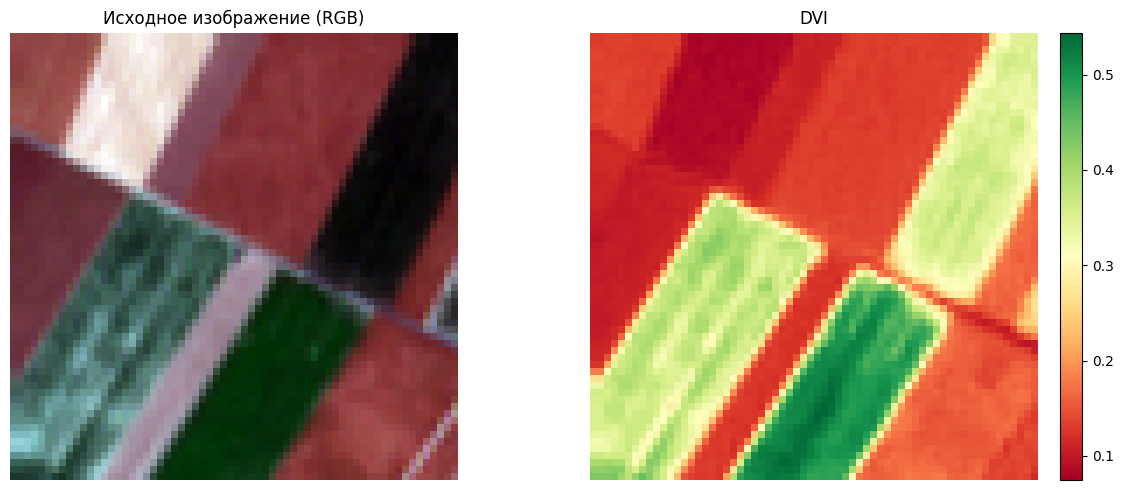

In [40]:
sample = ds[90]
display_index_from_sample(sample, params={'rho': 0.3, 'alpha': 0.78, 'a': 0.33, 's': 0.5, 'X': 0.08})